In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from os import path
from wienersvd import *

In [2]:
basepath = "/exp/sbnd/data/users/munjung/xsec/2025B"

In [3]:
# BNB-light data
fname = "DevData-elifetime35ms-wpot.df"
bnbdata_bnbpot = pd.read_hdf(path.join(basepath, fname), "bnbpot")
bnbdata = pd.read_hdf(path.join(basepath, fname), "evt")
bnbdata_pot = bnbdata_bnbpot["TOR875"].sum()
print("BNB+light data pot: {:.2e}".format(bnbdata_pot))

fname = "MC_bnbcosmics_test.df"
bnbmc_hdr = pd.read_hdf(path.join(basepath, fname), "hdr")
bnbmc = pd.read_hdf(path.join(basepath, fname), "evt")

goal_pot = bnbdata_pot
mc_pot = bnbmc_hdr[bnbmc_hdr.first_in_subrun == 1].pot.sum()
goal_scale = goal_pot/mc_pot
print("goal scale: {:.2f}".format(goal_scale))
bnbmc["pot_weight"] = goal_scale * np.ones(len(bnbmc))

BNB+light data pot: 4.60e+18
goal scale: 3.06


In [4]:
# additional cuts?
twoprong_cut = (np.isnan(bnbmc.other_shw_length) & np.isnan(bnbmc.other_trk_length))
bnbmc = bnbmc[twoprong_cut]

twoprong_cut = (np.isnan(bnbdata.other_shw_length) & np.isnan(bnbdata.other_trk_length))
bnbdata = bnbdata[twoprong_cut]

# Event rates

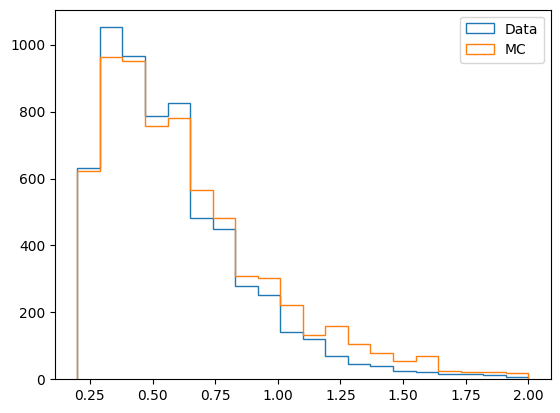

In [5]:
bins = np.linspace(0.2, 2, 21)
var_data = bnbdata.mu.pfp.trk.P.p_muon
var_mc = bnbmc.mu.pfp.trk.P.p_muon

Measure, _, _ = plt.hist(var_data, bins=bins, histtype="step", label="Data")
Signal, _, _ = plt.hist(var_mc, bins=bins, weights=bnbmc.pot_weight, histtype="step", label="MC")
plt.legend()
plt.show()

# Response

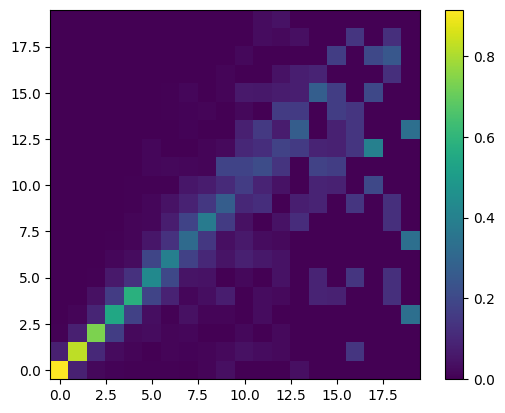

In [6]:
bnbmc["truth_totp"] = np.sqrt(bnbmc.mu.pfp.trk.truth.p.genp.x**2 + bnbmc.mu.pfp.trk.truth.p.genp.y**2 + bnbmc.mu.pfp.trk.truth.p.genp.z**2)
n, bins, _ = np.histogram2d(bnbmc.truth_totp, bnbmc.mu.pfp.trk.P.p_muon, bins=bins)

eff = 1
Response = eff * n.T/n.T.sum(axis=0)
plt.imshow(Response, origin="lower")
plt.colorbar()
plt.show();

# Covariance

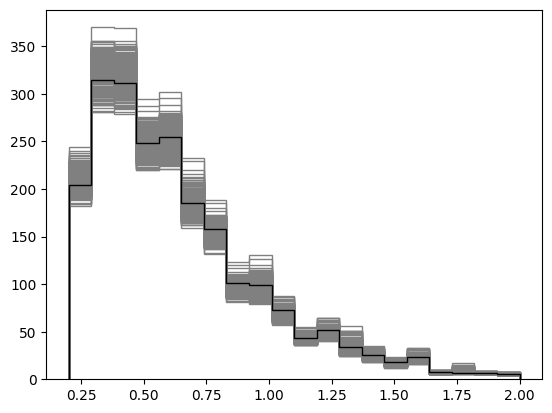

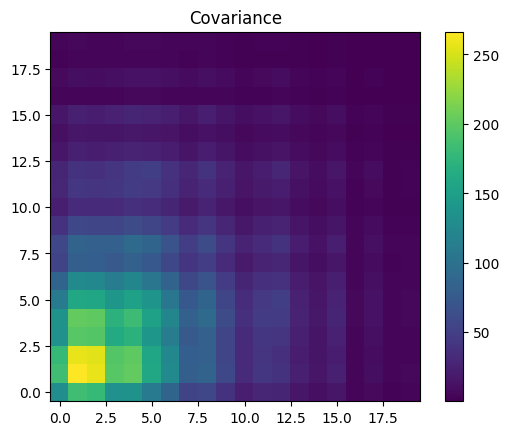

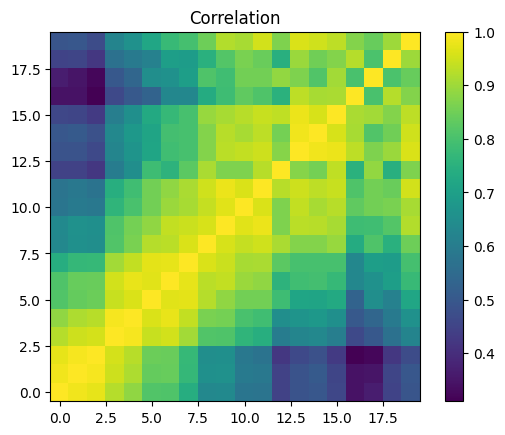

In [7]:
# flux
var = bnbmc.mu.pfp.trk.P.p_muon
bin_centers = (bins[:-1] + bins[1:])/2
univ_events = []
for uidx in range(250):
    weights = bnbmc["flux_univ_"+str(uidx)].copy()
    weights[np.isnan(weights)] = 1
    n, bins, _ = plt.hist(var, bins=bins, weights=weights, histtype="step", color="gray")
    univ_events.append(n)
plt.hist(var, bins=bins, histtype="step", color="k")
plt.show();

univ_events = np.array(univ_events)
Covariance = np.cov(univ_events, rowvar=False)
plt.imshow(Covariance, origin="lower")
plt.colorbar()
plt.title("Covariance")
plt.show();

corr = np.corrcoef(univ_events.T)
plt.imshow(corr, origin="lower")
plt.colorbar()
plt.title("Correlation")
plt.show();

# Try Unfolding

In [8]:
C_type = 1
Norm_type = 2
unfold = WienerSVD(Response, Signal, Measure, Covariance, C_type, Norm_type)

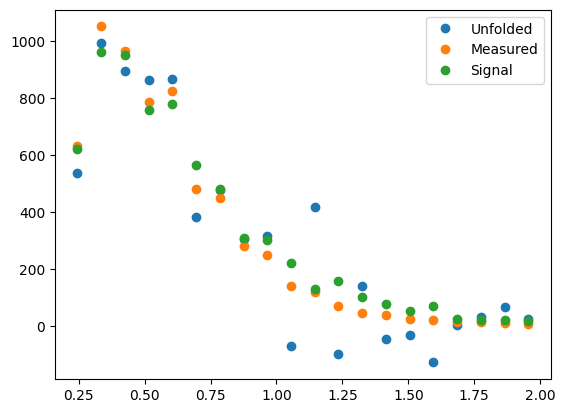

In [9]:
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
plt.plot(bin_centers, Unfold, 'o', label='Unfolded')
plt.plot(bin_centers, Measure, 'o', label='Measured')
plt.plot(bin_centers, Signal, 'o', label='Signal')
plt.legend()
plt.show()

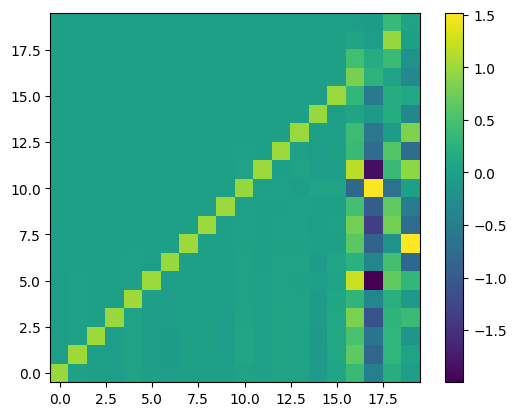

In [10]:
reg = unfold['AddSmear']
plt.imshow(reg, origin="lower")
plt.colorbar()
plt.show();